In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pylab as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc 
plt.style.use('ggplot') # Lets make our plots pretty

path = os.getcwd()

print(path)  

/Users/owner/Desktop/kagle_elo/Models


/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Read in the dataframes
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
merchants = pd.read_csv('../input/merchants.csv')
#new_merchants = pd.read_csv('../input/new_merchant_transactions.csv')
new_merchants = pd.read_csv('../input/nmt_replace.csv')
ss = pd.read_csv('../input/sample_submission.csv')

In [3]:
target = train['target']
del train['target']
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]
categorical_feats = [c for c in features if 'feature_' in c]

param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.7 ,
         "bagging_seed": 2015,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1}

In [4]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
#start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.


/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[100]	training's rmse: 3.84149	valid_1's rmse: 3.883
[200]	training's rmse: 3.84111	valid_1's rmse: 3.88262
[300]	training's rmse: 3.84087	valid_1's rmse: 3.88236
[400]	training's rmse: 3.84074	valid_1's rmse: 3.8822
[500]	training's rmse: 3.84065	valid_1's rmse: 3.88209
[600]	training's rmse: 3.84061	valid_1's rmse: 3.88204
[700]	training's rmse: 3.84058	valid_1's rmse: 3.88199
[800]	training's rmse: 3.84056	valid_1's rmse: 3.88196
[900]	training's rmse: 3.84055	valid_1's rmse: 3.88194
[1000]	training's rmse: 3.84054	valid_1's rmse: 3.88193
[1100]	training's rmse: 3.84054	valid_1's rmse: 3.88192
[1200]	training's rmse: 3.84053	valid_1's rmse: 3.88192
[1300]	training's rmse: 3.84053	valid_1's rmse: 3.88191
[1400]	training's rmse: 3.84053	valid_1's rmse: 3.88191
[1500]	training's rmse: 3.84053	valid_1's rmse: 3.88191
[1600]	training's rmse: 3.84053	valid_1's rmse: 3.8819
[1700]	training's rmse: 3.84053	valid_1's rmse: 3.8819
[1800]	training's rmse: 3.84053	valid_1's rmse: 3.8819
[1900]	

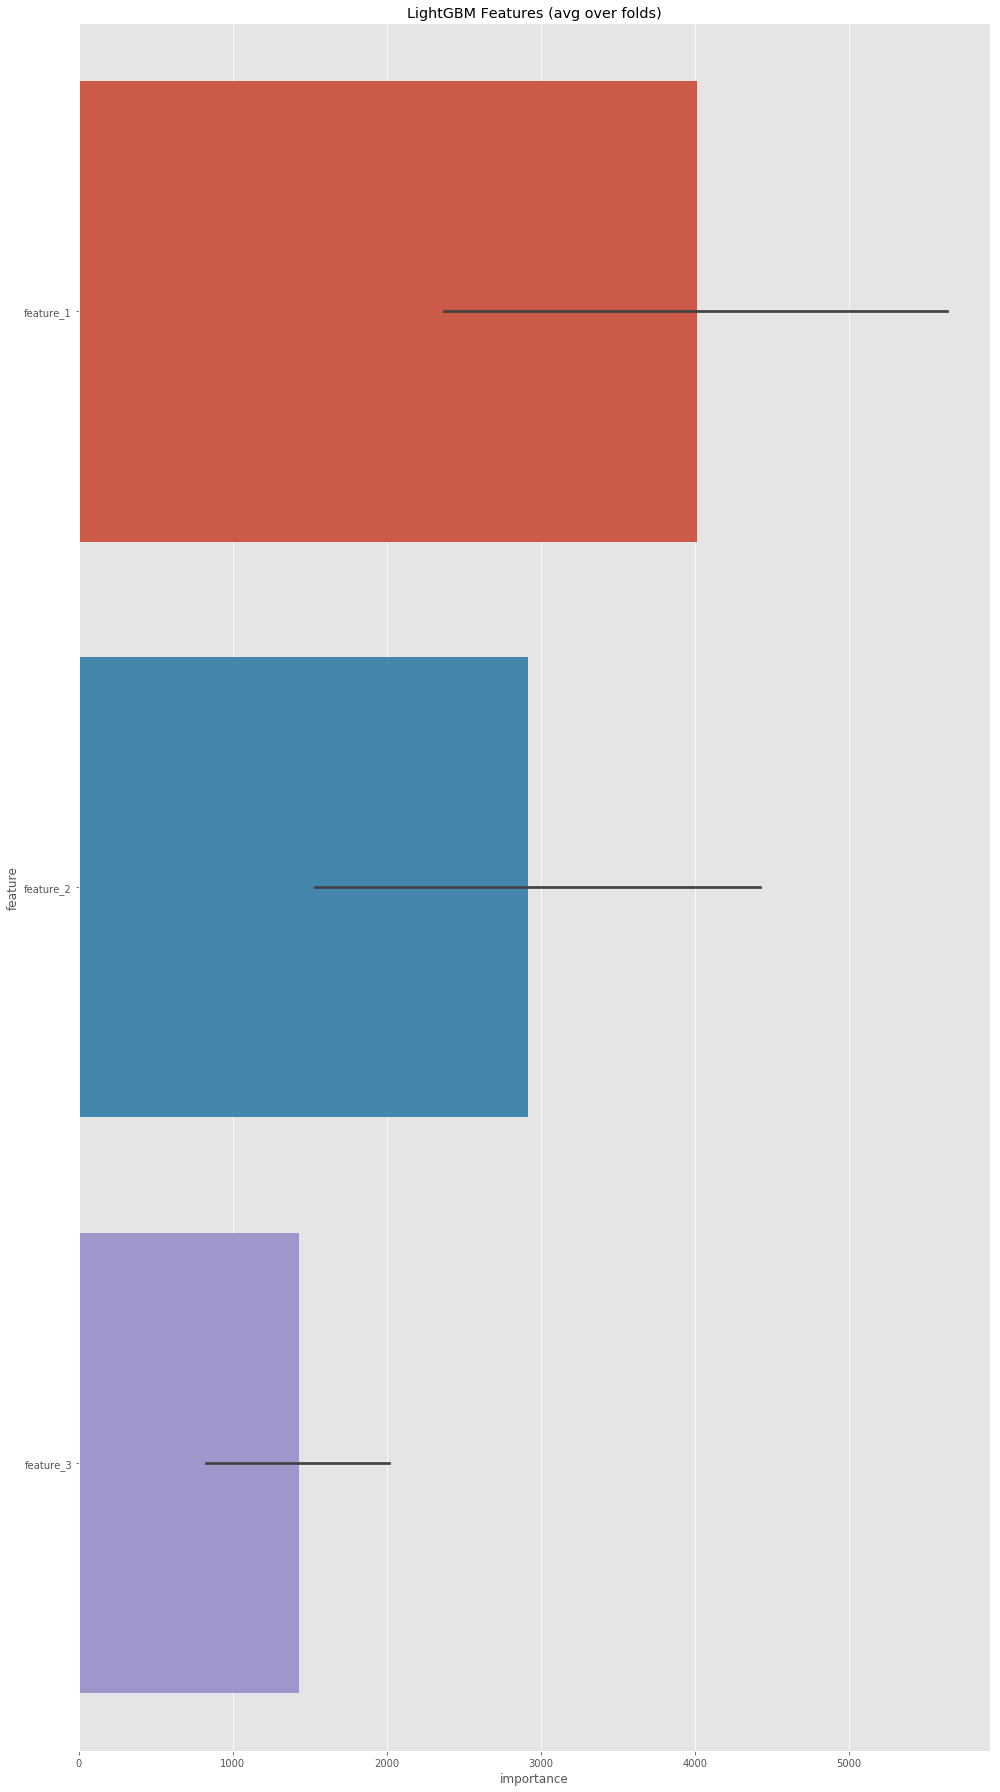

In [5]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:20].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [6]:
sub_df = pd.read_csv("../input//sample_submission.csv")
sub_df["target"] = predictions
sub_df.to_csv("submit_lgb2.csv", index=False)